In [2]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.optim as optim
import torch.distributions as dist
import numpy as np
import torch.nn.functional as F
from math import exp
import numpy as np
import matplotlib.pyplot as plt
from torch.autograd import Variable
import math
import time
import torch.nn.utils as utils

In [3]:
############################################
n=50000
xs = np.arange(-1.0, 1.0, 0.01)
xs_mf = np.arange(-1.0, 1.0, 0.02)
############################################
#func = torch.load('traindata_50000.pt')
#func_mf = torch.load('traindata_50000_fidelity2.pt')
func = torch.load('testdata_7000.pt')
func_mf = torch.load('testdata_7000_fidelity2.pt')
func=np.array(func)
func_mf=np.array(func_mf)

In [4]:
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array- value.data.numpy())).argmin()
    return idx

In [5]:
def query(action,func):
    y_out=[]
    x_out=[]
    for i in range(action.size(0)):
        idx=find_nearest(xs,action[i])
        y=func[i][idx]
        x_out.extend([xs[idx]])
        y_out.extend([y])
    x_out=np.array(x_out).reshape(action.size(0),1)
    x_out=torch.from_numpy(x_out[:])
    y_out=np.array(y_out).reshape(action.size(0),1)
    y_out=torch.from_numpy(y_out[:,:])
    input=torch.cat((x_out,y_out),1)
    return input,x_out,y_out

In [6]:
def query_mf(action,func,func_mf,fidelity):
    y_out=[]
    x_out=[] 
    for i in range(action.size(0)):
        if fidelity[i] ==0.:
            idx=find_nearest(xs_mf,action[i])
            y=func_mf[i][idx]
            x_out.extend([xs_mf[idx]])
        else :
            idx=find_nearest(xs,action[i])
            y=func[i][idx]
            x_out.extend([xs[idx]])
        y_out.extend([y])
    x_out=np.array(x_out).reshape(action.size(0),1)
    x_out=torch.from_numpy(x_out[:]).double()
    y_out=np.array(y_out).reshape(action.size(0),1)
    y_out=torch.from_numpy(y_out[:,:]).double()
    input=torch.cat((x_out,y_out),1)
    return input,x_out,y_out

In [7]:
def process(x0,func):
    inputs=[]
    x_out=[]
    y_out=[]
    idx=find_nearest(xs,x0)
    for i in range(func.size(0)):
        y=func[i][idx]
        x_out.extend([xs[idx]])
        y_out.extend([y])
    x_out=np.array(x_out).reshape(func.size(0),1)
    x_out=torch.from_numpy(x_out[:])
    y_out=np.array(y_out).reshape(func.size(0),1)
    y_out=torch.from_numpy(y_out[:,:])
    input=torch.cat((x_out,y_out),1)
    return input

In [8]:
np.random.seed(77)
torch.manual_seed(77)
    

#starting point
x0=torch.tensor([0.0])
step=20
future=0

hidden_size=64
sigma=0.1
n=2000

In [9]:
class Sequence_mf(nn.Module):
    def __init__(self):
        super(Sequence_mf, self).__init__()
        self.lstm1 = nn.LSTMCell(2,64)
        self.lstm2 = nn.LSTMCell(1,64)
        self.linear1= nn.Linear(64,1)
        self.linear2= nn.Linear(64,1)
        self.tanh=nn.Tanh()
        self.sigmoid=nn.Sigmoid()
        
    def forward(self,input,func,func_mf,sigma,future=0):
        outputs = []
        log_probs = []
        rewards = []
        entropies = []
        actions = []
        fidelity_all=[]
        time_step=[]
        
        h_t = torch.zeros(input.size(0), 64, requires_grad=False, dtype=torch.double).cuda()
        c_t = torch.zeros(input.size(0), 64, requires_grad=False, dtype=torch.double).cuda()
        
        h2_t = torch.zeros(input.size(0), 64, requires_grad=False, dtype=torch.double).cuda()
        c2_t = torch.zeros(input.size(0), 64, requires_grad=False, dtype=torch.double).cuda()
        
        outputs += [input]
        t0 = time.time()
        for i in range(step+future):
            h_t, c_t = self.lstm1(input, (h_t, c_t))
            h_t=h_t.detach()
            c_t=c_t.detach()
            mean=self.linear1(h_t)
            mean=self.tanh(mean)
            m = torch.distributions.normal.Normal(mean,sigma)
            action=m.sample()
            entropy=m.entropy()
            
            h2_t, c2_t = self.lstm2(action, (h2_t, c2_t))
            h2_t=h2_t.detach()
            c2_t=c2_t.detach()
            prob=self.linear2(h2_t)
            prob=self.sigmoid(prob)
            w = torch.distributions.bernoulli.Bernoulli(prob)
            
            fidelity=w.sample()
            
            ############################################
            #sigma-=0.0015
            
            #next input
            
            input,action_new,reward=query_mf(action.cpu(),func,func_mf,fidelity.cpu())
            log_prob=m.log_prob(action_new.cuda())
           
            input=input.cuda()
            outputs += [input]
            
            log_probs.append(log_prob)
            rewards.append(reward)
            entropies.append(entropy)
            actions.append(action_new)
            fidelity_all.append(fidelity.double())
            t1=time.time() - t0
            time_step.append(t1)
            
        outputs = torch.stack(outputs, 1).squeeze(2)
        return outputs,log_probs,rewards,entropies,actions,fidelity_all,time_step

In [10]:
class Sequence(nn.Module):
    def __init__(self):
        super(Sequence, self).__init__()
        self.lstm1 = nn.LSTMCell(2,hidden_size)
        self.linear1= nn.Linear(hidden_size,1)
        self.linear2= nn.Linear(hidden_size,1)
        self.tanh=nn.Tanh()
        
    def forward(self,input,func,sigma,future=0):
        outputs = []
        log_probs = []
        rewards = []
        entropies = []
        actions = []
        time_step=[]
        
        h_t = torch.zeros(input.size(0), hidden_size, requires_grad=False, dtype=torch.double).cuda()
        c_t = torch.zeros(input.size(0), hidden_size, requires_grad=False, dtype=torch.double).cuda()
        outputs += [input]
        t0 = time.time()
        for i in range(step+future):
            
            h_t, c_t = self.lstm1(input, (h_t, c_t))
            h_t=h_t.detach()
            c_t=c_t.detach()
            mean=self.linear1(h_t)
            mean=self.tanh(mean)
            #print('mean:',mean.detach().cpu().numpy())
            m = torch.distributions.normal.Normal(mean,sigma)
            action=m.sample()
            entropy=m.entropy()
            
            #sigma-=0.0015
            
            input,action_new,reward=query(action.cpu(),func)
            #print('action:',action_new)
            log_prob=m.log_prob(action_new.cuda())
            input=input.cuda()
            outputs += [input]
            
            log_probs.append(log_prob)
            rewards.append(reward)
            entropies.append(entropy)
            actions.append(action_new)
            t1=time.time() - t0
            time_step.append(t1)
            
            
        outputs = torch.stack(outputs, 1).squeeze(2)
        return outputs,log_probs,rewards,entropies,actions,time_step

In [11]:
def mins_found(rewards):
        min_step=[]    
        min_h=rewards[0].clone()
        for i in range(len(rewards)):
            for j in range(rewards[i].size(0)):
                if rewards[i][j]<min_h[j]:
                    min_h[j]=rewards[i][j]
            min_step.append(min_h.mean())
        return min_step

In [12]:
def min_loss(rewards):
        min_step=[]    
        min_h=rewards[0].clone()
        for i in range(len(rewards)):
            for j in range(rewards[i].size(0)):
                if rewards[i][j]<min_h[j]:
                    min_h[j]=rewards[i][j]
            min_step.append(min_h.clone())            
        return min_step

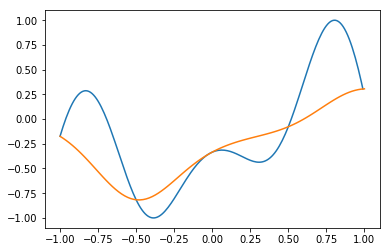

In [14]:
f=1111
#2 11
plt.plot(xs,func[f])
plt.plot(xs_mf,func_mf[f])
plt.show()

In [138]:
future=0
sigma=0.0
func_test = torch.from_numpy(func[f:f+1,:])
func_test_mf = torch.from_numpy(func_mf[f:f+1 :])
input_test=process(x0,func_test)
input_test=input_test.cuda()

In [16]:
seq1 = Sequence().cuda()
seq1.double()
seq1.load_state_dict(torch.load('seq37_100.pkl')) #oi37 #min 40 #sum31


In [17]:

t0 = time.time()
with torch.no_grad():
        out_test,log_probs,test_rewards,entropies,test_actions,time_step = seq1(input_test,func_test,sigma,future)
        t1=time.time() - t0
        min_step=mins_found(test_rewards)
        min_result=min_loss(test_rewards)
        std=[]
        for i in range(len(test_rewards)):
            std.append((((min_result[i]**2).sum() /len(test_rewards[0])-(min_result[i].mean())**2 )/len(test_rewards[0]))**0.5)
        y = out_test.cpu().detach().numpy()
print('time : {:.02e} seconds'.format(t1))

time : 2.42e-02 seconds


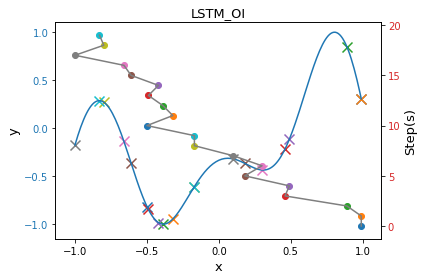

In [18]:
k =0
x = torch.linspace(0, 1)

color = 'tab:blue'
fig,ax1= plt.subplots()
ax1.set_title('LSTM_OI',size=13)
ax1.set_xlabel('x',size=13)
ax1.set_ylabel('y',size=13)

ax1.plot(xs,func[f])


ax1.tick_params(axis='y', labelcolor=color)
for i in range(step+future):
    ax1.scatter(y[k][i+1][0],y[k][i+1][1],marker='x',s=100)
#ax1.plot([1.0,1.0],[-2,2],'g--')

ax2 = ax1.twinx()

steps = np.arange(0, step+future, 1)
color = 'tab:red'
ax2.set_ylabel('Step(s)',size=13)  

ax2.plot(test_actions,steps, color='tab:grey')
ax2.tick_params(axis='y', labelcolor=color)
ax2.set_yticks(np.arange(0, step+future+1, 5))
for i in range(step+future):
    ax2.scatter(test_actions[i],i)

fig.tight_layout() 
#plt.savefig("plot_oi.pdf",bbox_inches="tight")

In [255]:
#mf
seq4 = Sequence_mf().cuda()
seq4.double()
seq4.load_state_dict(torch.load('seq73_100.pkl')) #sum 78 #min 62 #oi 73

In [262]:
sigma=0.1
t0 = time.time()
with torch.no_grad():
            out_test,log_probs,test_rewards,entropies,test_actions,fidelity,time_step4 = seq4(input_test,func_test,func_test_mf,sigma,future)
            t4=time.time() - t0
            min_step6=mins_found(test_rewards)
            min_result=min_loss(test_rewards)
            std6=[]
            for i in range(len(test_rewards)):
                std6.append((((min_result[i]**2).sum() /len(test_rewards[0])-(min_result[i].mean())**2 )/len(test_rewards[0]))**0.5)
            y = out_test.cpu().detach().numpy()
print('time : {:.02e} seconds'.format(t4))

time : 3.25e-02 seconds


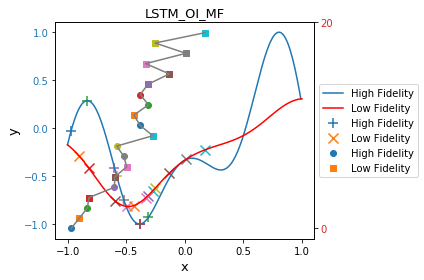

In [321]:
#multifidelity
k = 0
#plt.plot(xs,func_test[k].detach().numpy())
x = torch.linspace(0, 1)

color = 'tab:blue'
fig,ax1= plt.subplots()
ax1.set_title('LSTM_OI_MF',size=13)
ax1.set_xlabel('x',size=13)
ax1.set_ylabel('y',size=13)
#GP
ax1.plot(xs,func[f],label='High Fidelity')
ax1.plot(xs_mf,func_mf[f],color='red',label='Low Fidelity')

ax1.tick_params(axis='y', labelcolor=color)


#for i in range(step+future):
#    ax1.scatter(test_actions[i],test_rewards[i],marker='o',s=100)
count=0
for i in range(step+future):
    if fidelity[i] == 0:
        if count==1:
            ax1.scatter(y[k][i+1][0],y[k][i+1][1],marker='x',s=100,label='Low Fidelity')
            count+=1
        else:
            ax1.scatter(y[k][i+1][0],y[k][i+1][1],marker='x',s=100)
    else: 
        if count==0:
            ax1.scatter(y[k][i+1][0],y[k][i+1][1],marker='+',s=100,label='High Fidelity')
            count+=1
        else:
            ax1.scatter(y[k][i+1][0],y[k][i+1][1],marker='+',s=100)
#ax1.plot([1.0,1.0],[-2,2],'g--')
#ax1.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.8)

cost=0
cost_all=[]
#cost_all.append(cost)

ax2 = ax1.twinx()

steps = np.arange(0, step+future, 1)
color = 'tab:red'
#ax2.set_ylabel('Step(s)',size=13)  

ax2.plot(test_actions,steps, color='tab:grey')
ax2.tick_params(axis='y', labelcolor=color)
ax2.set_yticks(np.arange(0, step+future+1, 20))
count=0
for i in range(step+future):
    if fidelity[i] == 0:
        if count==1:
            count+=1
            ax2.scatter(test_actions[i],i,marker='s',label='Low Fidelity')
        else:
            ax2.scatter(test_actions[i],i,marker='s')
            #cost+=1.
    else:
        if count==0:
            count+=1
            ax2.scatter(test_actions[i],i,marker='o',label='High Fidelity')
        else:
            ax2.scatter(test_actions[i],i,marker='o')
        #cost+=10.
    #cost_all.append(cost)
ax2.set_ylim(-1,20)

lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc='center left', bbox_to_anchor=(1, 0.5))
#ax.legend(lns, labs,bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.8)

#remove errorbar in legend
#ax = plt.gca()
#handles, labels = ax.get_legend_handles_labels()
#handles = [h[0] if isinstance(h,container.ErrorbarContainer) else h for h in handles]


#ax.legend(handles, labels,bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)


fig.tight_layout() 
#plt.savefig("plot_oimf.pdf",bbox_inches="tight")
#plt.show()